# A1: Data Curation
Ruian Yang \
10/07/2020

## Import necessary packages and libraries

In [43]:
import json
import requests

import pandas as pd
import seaborn as sns
import numpy as np

## Step 1: Gathering the data
Collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API, to measure Wikipedia traffic from 2008-2020.

The Legacy Pagecounts API provides access to desktop and mobile traffic data from December 2007 through July 2016. \
The Pageviews API provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month. 

Legacy Pagecount Get Requests \
https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2007120100/2016070100
https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2007120100/2016070100

Pageviews Get Requests \
http://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/mobile-app/user/monthly/2015070100/2020090100
https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/mobile-web/user/monthly/2015070100/2020090100
http://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/desktop/user/monthly/2015070100/2020090100


In [44]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [45]:
# Parameters for getting legacy desktop traffic data
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016070100"
                    }

# Parameters for getting legacy mobile traffic data
params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016070100"
                    }

In [46]:
# Parameters for getting pageviews desktop traffic data
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                 "access" : "desktop",
                 "agent" : "user",
                 "granularity" : "monthly",
                 "start" : "2015070100",
                 "end" : "2020090100"
                    }

# Parameters for getting pageviews mobile web traffic data
params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                 "access" : "mobile-web",
                 "agent" : "user",
                 "granularity" : "monthly",
                 "start" : "2015070100",
                 "end" : "2020090100"
                    }

# Parameters for getting pageviews mobile app traffic data
params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                 "access" : "mobile-app",
                 "agent" : "user",
                 "granularity" : "monthly",
                 "start" : "2015070100",
                 "end" : "2020090100"
                    }

In [47]:
def api_call(endpoint,parameters):
    """
    :param endpoint: the Wikipedia API for the GET request
    :param parameters: the dictionary that contains values for the GET request
    :returns: JSON contianing the result from the GET request
    This function calls the API and gets a JSON response
    """
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [48]:
# Get legacy desktop traffic data
response_legacy_desktop = api_call(endpoint_legacy, params_legacy_desktop)
with open('pageviews_desktop_200712-201607.json', 'w') as f:
    json.dump(response_legacy_desktop, f)

# Get legacy mobile traffic data
response_legacy_mobile = api_call(endpoint_legacy, params_legacy_mobile)
with open('pageviews_mobile_200712-201607.json', 'w') as f:
    json.dump(response_legacy_mobile, f)

In [49]:
# Get pageviews desktop traffic data
response_pageviews_desktop =api_call(endpoint_pageviews, params_pageviews_desktop)
with open('pagecounts_desktop_201507-202009.json', 'w') as f:
    json.dump(response_pageviews_desktop, f)

# Get pageviews mobile web traffic data    
response_pageviews_mobile_web = api_call(endpoint_pageviews, params_pageviews_mobile_web)
with open('pagecounts_mobile_web_201507-202009.json', 'w') as f:
    json.dump(response_pageviews_mobile_web, f)

# Get pageviews mobile app traffic data 
response_pageviews_mobile_app = api_call(endpoint_pageviews, params_pageviews_mobile_app)
with open('pagecounts_mobile_app_201507-202009.json', 'w') as f:
    json.dump(response_pageviews_mobile_app, f)

## Step 2: Processing the data
Process the 5 JSON files obtained from calling the Legacy and the Pageviews APIs and combine the data into one csv file including the following columns:\
year, month, pagecount_all_views, pagecount_desktop_views, pagecount_mobile_views, pageview_all_views, pageview_desktop_views, pageview_mobile_views


In [50]:
# Create pandas dataframes for each JSON file 
df_pageviews_desktop = pd.DataFrame(response_legacy_desktop['items'])
df_pageviews_mobile = pd.DataFrame(response_legacy_mobile['items'])

df_pagecounts_desktop = pd.DataFrame(response_pageviews_desktop['items'])
df_pagecounts_mobile_web = pd.DataFrame(response_pageviews_mobile_web['items'])
df_pagecounts_mobile_app = pd.DataFrame(response_pageviews_mobile_app['items'])

In [51]:
# Add new column that combines mobile and desktop pageviews
df_pageviews_all = (df_pageviews_desktop.merge(df_pageviews_mobile, on=['timestamp', 'project', 'granularity'], how='left'))
df_pageviews_all = df_pageviews_all.rename(columns={"count_x": "pageview_desktop_views", "count_y": "pageview_mobile_views"})
df_pageviews_all['pageview_all_views'] = df_pageviews_all['pageview_desktop_views'].add(df_pageviews_all['pageview_mobile_views'], fill_value=0)

# Drop unnecessary columns
df_pageviews_all = df_pageviews_all.drop(['project','granularity','access-site_x','access-site_y'], axis=1)

In [52]:
# Change timestamp to year and month columns for pageview data
df_pageviews_all['year'] = df_pageviews_all['timestamp'].astype(str).str[:4]
df_pageviews_all['month'] = df_pageviews_all['timestamp'].astype(str).str[4:6]
df_pageviews_all = df_pageviews_all.drop('timestamp', axis=1)

In [53]:
# Add new column that combines mobile web and mobile app pagecounts
df_pagecounts_mobile = (df_pagecounts_mobile_app.merge(df_pagecounts_mobile_web, on=['timestamp', 'project', 'granularity', 'agent'], how='left'))
df_pagecounts_mobile['pagecount_mobile_views'] = df_pagecounts_mobile['views_x'].add(df_pagecounts_mobile['views_y'], fill_value=0)

# Drop unnecessary columns
df_pagecounts_mobile = df_pagecounts_mobile.drop(['project','granularity','agent','access_x','access_y','views_x','views_y'], axis=1)

# Add new column that combines mobile and desktop pagecounts
df_pagecounts_all = (df_pagecounts_desktop.merge(df_pagecounts_mobile, on=['timestamp'], how='left'))
df_pagecounts_all['pagecount_all_views'] = df_pagecounts_all['views'].add(df_pagecounts_all['pagecount_mobile_views'], fill_value=0)
df_pagecounts_all = df_pagecounts_all.rename(columns={"views": "pagecount_desktop_views"})

# Drop unnecessary columns
df_pagecounts_all = df_pagecounts_all.drop(['project','granularity','agent','access'], axis=1)

In [54]:
# Change timestamp to year and month columns for pagecount data
df_pagecounts_all['year'] = df_pagecounts_all['timestamp'].astype(str).str[:4]
df_pagecounts_all['month'] = df_pagecounts_all['timestamp'].astype(str).str[4:6]
df_pagecounts_all = df_pagecounts_all.drop('timestamp', axis=1)

In [55]:
# Combine pageview and pagecount data
df_wikipedia_traffic = (df_pageviews_all.merge(df_pagecounts_all, on=['year','month'], how='outer'))

# Replace nan values with 0 and set all view columns to type int
df_wikipedia_traffic = df_wikipedia_traffic.fillna(0).astype({'pageview_desktop_views': 'int', 'pageview_mobile_views': 'int', 'pageview_all_views': 'int', 
                                                             'pagecount_desktop_views': 'int', 'pagecount_mobile_views': 'int', 'pagecount_all_views': 'int'})

# Adjust the order of the columns 
df_wikipedia_traffic = df_wikipedia_traffic[['year','month','pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views',
                                             'pageview_all_views','pageview_desktop_views','pageview_mobile_views']]

In [56]:
# Save all the traffic data as a csv file
df_wikipedia_traffic.to_csv('en-wikipedia_traffic_200712-202009.csv')

## Step 3: Analyze the data
Visualize the data using lineplot for different traffic metrics using Seaborn and the pandas dataframe including all traffic data generate in step 2.

In [57]:
# Create dates for the x axis
dates = pd.date_range('2007-12', '2020-09', freq='M')

# Replace zeros with nan so they don't show up on the plot
df_wikipedia_traffic = df_wikipedia_traffic.replace(to_replace=0, value=np.nan)

Text(0.5, 1.0, 'Page views on English Wikipedia, 2008.01 - 2020.08')

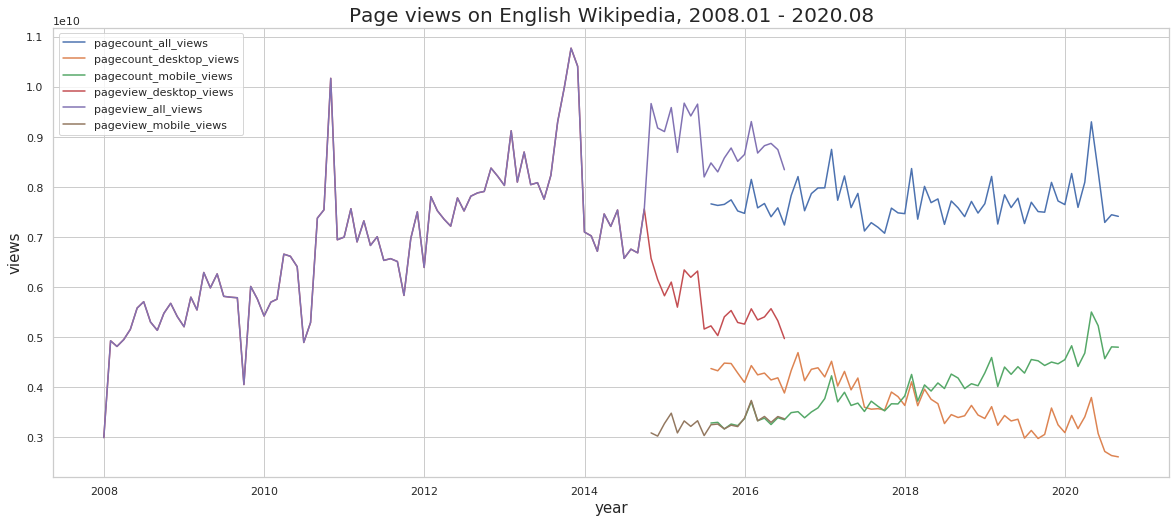

In [59]:
# Set plot style
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set_style("whitegrid")

# Plot each type of wikipedia view
ax = sns.lineplot(x=dates, y=df_wikipedia_traffic.pagecount_all_views, label='pagecount_all_views')
ax = sns.lineplot(x=dates, y=df_wikipedia_traffic.pagecount_desktop_views, label='pagecount_desktop_views')
ax = sns.lineplot(x=dates, y=df_wikipedia_traffic.pagecount_mobile_views, label='pagecount_mobile_views')
ax = sns.lineplot(x=dates, y=df_wikipedia_traffic.pageview_desktop_views, label='pageview_desktop_views')
ax = sns.lineplot(x=dates, y=df_wikipedia_traffic.pageview_all_views, label='pageview_all_views')
ax = sns.lineplot(x=dates, y=df_wikipedia_traffic.pageview_mobile_views, label='pageview_mobile_views')
ax.set_xlabel('year', fontsize = 15)
ax.set_ylabel('views', fontsize = 15)
ax.legend()
ax.set_title('Page views on English Wikipedia, 2008.01 - 2020.08', fontsize = 20)

In [60]:
# Save plot as a png file
ax.figure.savefig("en-wikipedia_plot.png")